In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import os
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import statsmodels.tsa.stattools as sts
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import AR
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
import time
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.svm import SVC,SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,StandardScaler,Normalizer
from sklearn.metrics import r2_score,mean_squared_error

In [2]:
env='train'

In [3]:
if env == 'test' :
    train_action = pd.read_csv(r"C:\Users\kobi_z\Documents\Data Science\Simpool Projects\test data\test1_3.csv")
    train_deposits = pd.read_csv(r"C:\Users\kobi_z\Documents\Data Science\Simpool Projects\test data\test2_v2.csv")
    train_user_prop = pd.read_csv(r"C:\Users\kobi_z\Documents\Data Science\Simpool Projects\test data\test3_v2.csv")
if env == 'train':
    train_action = pd.read_csv(r"C:\Users\kobi_z\Documents\Data Science\Simpool Projects\Training data\train1_3.csv")
    train_deposits = pd.read_csv(r"C:\Users\kobi_z\Documents\Data Science\Simpool Projects\Training data\train2_v2.csv")
    train_user_prop = pd.read_csv(r"C:\Users\kobi_z\Documents\Data Science\Simpool Projects\Training data\train3_v2.csv")

In [4]:
df_mid=pd.concat([train_action,train_deposits.rename(columns={'transaction_time':'placed_time','amount':'win_or_lose_amount','type':'settlement_status'})],ignore_index=False)
df=pd.merge(left=df_mid,right=train_user_prop,left_on='user_id',right_on='user_id')

In [5]:
df.head()

,user_id,placed_time,total_stake,bet_type,settlement_status,settlement_time,win_or_lose_amount,price,odd_count,currency,freebet_stake,odd_booster,source,campaign_name,registration_platform,registration_date
0,521331,2019-12-01 00:08:32.000000,10.0,MULTIPLE,LOST,2019-12-01 13:29:10.000000,0.00,2.88927,3.0,GBP,0.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019
1,521331,2019-12-02 16:00:57.000000,0.0,MULTIPLE,LOST,2019-12-04 21:23:03.000000,0.00,18.80158,6.0,GBP,10.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019
2,521331,2019-12-02 23:07:10.000000,0.0,MULTIPLE,WON,2019-12-07 17:11:23.000000,22.46,3.24635,3.0,GBP,10.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019
3,521331,2019-12-06 10:33:53.000000,0.0,MULTIPLE,LOST,2019-12-07 21:43:35.000000,0.00,28.48877,6.0,GBP,10.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019
4,521331,2019-12-24 17:38:12.000000,0.0,MULTIPLE,LOST,2019-12-26 16:59:42.000000,0.00,16.29976,4.0,GBP,1.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019


In [6]:
df.placed_time=pd.to_datetime(df.placed_time,dayfirst=True)
df.settlement_time=pd.to_datetime(df.settlement_time,dayfirst=True)

In [7]:
first_activity=df.groupby('user_id')['placed_time'].min()
df=pd.merge(df,first_activity,left_on='user_id',right_on='user_id',how='left')

In [8]:
df=df.rename(columns={'placed_time_y':'min_date','placed_time_x':'placed_time'})
df.head()

,user_id,placed_time,total_stake,bet_type,settlement_status,settlement_time,win_or_lose_amount,price,odd_count,currency,freebet_stake,odd_booster,source,campaign_name,registration_platform,registration_date,min_date
0,521331,2019-12-01 00:08:32,10.0,MULTIPLE,LOST,2019-12-01 13:29:10,0.00,2.88927,3.0,GBP,0.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019,2019-12-01 00:08:32
1,521331,2019-12-02 16:00:57,0.0,MULTIPLE,LOST,2019-12-04 21:23:03,0.00,18.80158,6.0,GBP,10.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019,2019-12-01 00:08:32
2,521331,2019-12-02 23:07:10,0.0,MULTIPLE,WON,2019-12-07 17:11:23,22.46,3.24635,3.0,GBP,10.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019,2019-12-01 00:08:32
3,521331,2019-12-06 10:33:53,0.0,MULTIPLE,LOST,2019-12-07 21:43:35,0.00,28.48877,6.0,GBP,10.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019,2019-12-01 00:08:32
4,521331,2019-12-24 17:38:12,0.0,MULTIPLE,LOST,2019-12-26 16:59:42,0.00,16.29976,4.0,GBP,1.0,0.0,Snapchat,bidalgo_SC-19/20(Cons-Eng)_IOS_Install_Install,IOS,01/12/2019,2019-12-01 00:08:32


In [9]:
df['seniority']=df['placed_time']-df['min_date']

In [10]:
player_char=[]
for user in df['user_id'].unique():
    df_user=df[df['user_id']==user]
    df_user_bets=df_user[(df_user['settlement_status']!='DEPOSIT')&(df_user['settlement_status']!='WITHDRAWAL')]
    num_of_bets=df_user[df_user['total_stake']>0].shape[0]
    num_of_free_bets=df_user[df_user['freebet_stake']>0].shape[0]
    num_of_win_bets=df_user_bets[df_user_bets['settlement_status']=='WON'].shape[0]
    win_bets_amount=df_user_bets[df_user_bets['settlement_status']=='WON']['win_or_lose_amount'].sum()
    num_of_lost_bets=df_user_bets[df_user_bets['settlement_status']=='LOST'].shape[0]
    lost_bets_amount=df_user_bets[df_user_bets['settlement_status']=='LOST']['total_stake'].sum()+df_user_bets[df_user_bets['settlement_status']=='LOST']['freebet_stake'].sum()
    deposite_amount=df_user[df_user['settlement_status']=='DEPOSIT']['win_or_lose_amount'].sum()
    withdrawal_amount=df_user[df_user['settlement_status']=='WITHDRAWAL']['win_or_lose_amount'].sum()
    num_bet_days=df_user_bets['placed_time'].dt.date.unique().shape[0]
    first2last_days_bet=(df_user_bets['placed_time'].max()-df_user_bets['placed_time'].min()).days
    odd_count=df_user_bets['odd_count'].median()
    odd_boost=df_user_bets['odd_booster'].median()
    seniority=df_user['seniority'].max().days
    GGR=df_user[df_user['settlement_status']=='DEPOSIT']['win_or_lose_amount'].sum()-df_user[df_user['settlement_status']=='WITHDRAWAL']['win_or_lose_amount'].sum()
    NGR=GGR-df_user_bets['freebet_stake'].sum()
    Stake_ratio=0.14*df_user_bets['total_stake'].sum()
    player_char.append([user,num_of_bets,num_of_free_bets,num_of_win_bets,win_bets_amount,num_of_lost_bets,lost_bets_amount,deposite_amount,withdrawal_amount,num_bet_days,first2last_days_bet,odd_count,odd_boost,seniority,GGR,NGR,Stake_ratio])

In [11]:
player_char_df=pd.DataFrame(player_char)
player_char_df.columns=['user','num_of_bets','num_of_free_bets','num_of_win_bets','win_bets_amount','num_of_lost_bets','lost_bets_amount','deposite_amount','withdrawal_amount','num_bet_days','first2last_days_bet','odd_count','odd_boost','seniority','GGR','NGR','Stake_ratio']

In [12]:
player_char_df.shape

(5000, 17)

# Extracting Features for df_train

In [13]:
df_train=pd.DataFrame([])
excluded_users=[]
for user in df['user_id'].unique():
    try:
        user_start_date=df[(df['settlement_status']=='DEPOSIT')&(df['user_id']==user)].sort_values(by='placed_time',ascending=True).reset_index()['placed_time'][0]
        user_end_date=user_start_date+datetime.timedelta(days=21)
        df_user=df[(df['placed_time']>=user_start_date)&(df['placed_time']<=user_end_date)&(df['user_id']==user)]
        df_train=pd.concat([df_train,df_user])
    except:
        IndexError
        excluded_users.append([user,'No Deposit Found'])


In [14]:
#df_train.to_csv(r'C:\Users\kobi_z\Documents\Data Science\Simpool Projects\Training data\df_train_test.csv')

In [15]:
len(df_train['user_id'].unique())

2637

In [16]:
#df_train=pd.read_csv(r'C:\Users\kobi_z\Documents\Data Science\Simpool Projects\Training data\df_train.csv',encoding='ISO8859-1')

In [17]:
user_wo_deposit=len(excluded_users)
user_wo_deposit

2363

In [18]:
for user in df['user_id'].unique():
    withdrawal=df[(df['user_id']==user)&(df['settlement_status']=='WITHDRAWAL')]['win_or_lose_amount'].sum()
    deposit=df[(df['user_id']==user)&(df['settlement_status']=='DEPOSIT')]['win_or_lose_amount'].sum()
    win=df[(df['user_id']==user)&(df['settlement_status']=='WON')]['win_or_lose_amount'].sum()
    lost=df[(df['user_id']==user)&(df['settlement_status']=='LOST')]['win_or_lose_amount'].sum()

    if (withdrawal+lost>win+deposit):
        excluded_users.append([user,'Withdrawal greater than sum of wins'])
    else:
        pass

In [19]:
df_ex=pd.DataFrame(excluded_users)
df_ex.columns=['user','comment']

In [20]:
num_of_high_withdrawal=df_ex[df_ex['comment']=='Withdrawal greater than sum of wins'].shape[0]
num_of_high_withdrawal

372

In [21]:
player_char_train=[]
for user in df_train['user_id'].unique():
    df_user=df_train[df_train['user_id']==user]
    df_user_bets=df_user[(df_user['settlement_status']!='DEPOSIT')&(df_user['settlement_status']!='WITHDRAWAL')]
    num_of_bets=df_user[df_user['total_stake']>0].shape[0]
    num_of_free_bets=df_user[df_user['freebet_stake']>0].shape[0]
    num_of_win_bets=df_user_bets[df_user_bets['settlement_status']=='WON'].shape[0]
    win_bets_amount=df_user_bets[df_user_bets['settlement_status']=='WON']['win_or_lose_amount'].sum()
    num_of_lost_bets=df_user_bets[df_user_bets['settlement_status']=='LOST'].shape[0]
    lost_bets_amount=df_user_bets[df_user_bets['settlement_status']=='LOST']['total_stake'].sum()+df_user_bets[df_user_bets['settlement_status']=='LOST']['freebet_stake'].sum()
    deposite_amount=df_user[df_user['settlement_status']=='DEPOSIT']['win_or_lose_amount'].sum()
    withdrawal_amount=df_user[df_user['settlement_status']=='WITHDRAWAL']['win_or_lose_amount'].sum()
    num_bet_days=df_user_bets['placed_time'].dt.date.unique().shape[0]
    first2last_days_bet=(df_user_bets['placed_time'].max()-df_user_bets['placed_time'].min()).days
    odd_count=df_user_bets['odd_count'].median()
    odd_boost=round(df_user_bets['odd_booster'].median(),1)
    seniority=df_user['seniority'].max().days
    GGR=df_user[df_user['settlement_status']=='DEPOSIT']['win_or_lose_amount'].sum()-df_user[df_user['settlement_status']=='WITHDRAWAL']['win_or_lose_amount'].sum()
    NGR=GGR-df_user_bets['freebet_stake'].sum()
    Stake_ratio=0.14*df_user_bets['total_stake'].sum()
    player_char_train.append([user,num_of_bets,num_of_free_bets,num_of_win_bets,win_bets_amount,num_of_lost_bets,lost_bets_amount,deposite_amount,withdrawal_amount,num_bet_days,first2last_days_bet,odd_count,odd_boost,seniority,GGR,NGR,Stake_ratio])

In [22]:
player_char_df_train=pd.DataFrame(player_char_train)
player_char_df_train.columns=['user','num_of_bets','num_of_free_bets','num_of_win_bets','win_bets_amount','num_of_lost_bets','lost_bets_amount','deposite_amount','withdrawal_amount','num_bet_days','first2last_days_bet','odd_count','odd_boost','seniority','GGR','NGR','Stake_ratio']

In [ ]:
#Test

In [81]:
test=df_train[(df_train['user_id']==521352)&(df_train['bet_type']=='MULTIPLE')]
test['date']=test['placed_time'].dt.date
test=test.set_index('date')
#test=test.asfreq('d')
test1=test.groupby('date')['win_or_lose_amount'].sum()
test1=test1.asfreq('d').fillna(0)
test1

C:\Users\kobi_z\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


date
2019-12-04    11.80
2019-12-05     6.80
2019-12-06     0.00
2019-12-07     0.00
2019-12-08     0.00
2019-12-09     9.04
Freq: D, Name: win_or_lose_amount, dtype: float64

In [82]:
start_date=test1.index[0]
end_date=start_date+datetime.timedelta(days=21)


In [84]:
test1.loc[end_date]=np.nan

In [90]:
test1.index[0]

Timestamp('2019-12-04 00:00:00')

In [79]:
L = 21-test1.shape[0]
i=0
while i<=L:
    i+=1
    last_date = test1.index[-1] + pd.Timedelta(days=1)
    test1.loc[last_date]=0

In [80]:
test1

date
2019-12-04    11.80
2019-12-05     6.80
2019-12-06     0.00
2019-12-07     0.00
2019-12-08     0.00
2019-12-09     9.04
2019-12-10     0.00
2019-12-11     0.00
2019-12-12     0.00
2019-12-13     0.00
2019-12-14     0.00
2019-12-15     0.00
2019-12-16     0.00
2019-12-17     0.00
2019-12-18     0.00
2019-12-19     0.00
2019-12-20     0.00
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
Freq: D, Name: win_or_lose_amount, dtype: float64

In [ ]:
#Test

In [23]:
df_train_svm=player_char_df_train[(player_char_df_train['seniority']<=15)|(player_char_df_train['num_bet_days']<=3)]
df_train_svm.shape

(1669, 17)

In [24]:
player_char_df_y=player_char_df[['user','GGR','NGR','Stake_ratio']]
player_char_df_y=player_char_df_y.rename(columns={'GGR':'GGR_y','NGR':'NGR_y','Stake_ratio':'Stake_ratio_y'})
player_char_df_y.head()

,user,GGR_y,NGR_y,Stake_ratio_y
0,521331,-17.0,-57.0,2.1644
1,488622,10.0,10.0,2.1000
2,521335,10.0,10.0,0.1134
3,521352,6.0,-24.0,7.5040
4,513063,0.0,-5.0,0.0000


In [94]:
#player_char_df.to_csv(r'C:\Users\kobi_z\Documents\Data Science\Simpool Projects\player_char.csv')

In [95]:
combined_df_train_svm=pd.merge(left=df_train_svm,right=player_char_df_y,left_on='user',right_on='user')

In [96]:
combined_df_train_svm=combined_df_train_svm.fillna(0)

In [97]:
combined_df_train_svm.shape

(658, 20)

In [98]:
ex_mask=combined_df_train_svm['user'].isin(df_ex['user'])

In [99]:
combined_df_train_svm=combined_df_train_svm[~ex_mask].reset_index()
combined_df_train_svm.shape

(627, 21)

In [100]:
combined_df_train_svm.head()

,index,user,num_of_bets,num_of_free_bets,num_of_win_bets,win_bets_amount,num_of_lost_bets,lost_bets_amount,deposite_amount,withdrawal_amount,num_bet_days,first2last_days_bet,odd_count,odd_boost,seniority,GGR,NGR,Stake_ratio,GGR_y,NGR_y,Stake_ratio_y
0,0,521500,0,2,0,0.00,2,20.00,10.0,55.0,1,0.0,3.0,0.0,1,-45.0,-65.0,0.0000,-45.0,-75.0,1.4000
1,1,521076,1,0,0,0.00,1,5.00,5.0,0.0,1,0.0,4.0,5.0,1,5.0,5.0,0.7000,-198.0,-228.0,2.1000
2,2,518785,10,0,4,185.66,6,36.86,35.0,150.0,5,5.0,5.0,0.2,13,-115.0,-115.0,10.9452,-115.0,-145.0,12.3452
3,3,521872,3,0,0,0.00,3,10.00,10.0,0.0,1,0.0,3.0,15.2,3,10.0,10.0,1.4000,-38.0,-68.0,4.9504
4,4,521887,6,2,2,14.54,6,13.08,10.0,0.0,6,5.0,3.5,0.0,13,10.0,6.5,2.5956,10.0,-23.5,3.9956


In [101]:
X=combined_df_train_svm[['num_of_bets','num_of_free_bets','num_of_win_bets','win_bets_amount','num_of_lost_bets','lost_bets_amount','deposite_amount','withdrawal_amount','num_bet_days','first2last_days_bet','odd_count','odd_boost','seniority','GGR','NGR','Stake_ratio']].to_numpy()
Y_ngr=combined_df_train_svm['NGR_y'].to_numpy()
Y_ggr=combined_df_train_svm['GGR_y'].to_numpy()
Y_r=combined_df_train_svm['Stake_ratio_y'].to_numpy()

In [54]:
pipeline_model=Pipeline(steps=[('scale',StandardScaler()),('svm',SVR())])
grid_param={'svm__C':[5,10,15,20,25,30,50], 'svm__kernel': ['rbf','linear','poly','sigmoid'],'svm__degree' : [1,2,3,5,8],'svm__max_iter': [3,5,7,100,150,300,500,700,1000]}

gd_sr = GridSearchCV(estimator=pipeline_model,
                     param_grid=grid_param,
                     scoring='r2',
                     cv=3,
                     n_jobs=-1)

### NGR

In [55]:
gd_sr.fit(X,Y_ngr)

C:\Users\kobi_z\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'svm__C': [5, 10, 15, 20, 25, 30, 50],
                         'svm__degree': [1, 2, 3, 5, 8],
                         'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                         'svm__max_iter': [3, 5, 7, 100, 150, 300, 500, 700,
                                           1000]},
             scoring='r2')

In [56]:
gd_sr.best_score_

0.7510594461970014

In [57]:
gd_sr.best_params_

{'svm__C': 25, 'svm__degree': 1, 'svm__kernel': 'linear', 'svm__max_iter': 700}

In [58]:
model_ngr=Pipeline(steps=[('scale',StandardScaler()),('svm',SVR(C=25,degree=1,kernel='linear',max_iter=700))])
model_ngr.fit(X,Y_ngr)

C:\Users\kobi_z\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('scale', StandardScaler()),
                ('svm', SVR(C=25, degree=1, kernel='linear', max_iter=700))])

In [102]:
y_hat_ngr=model_ngr.predict(X)

### GGR

In [60]:
gd_sr.fit(X,Y_ggr)

C:\Users\kobi_z\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'svm__C': [5, 10, 15, 20, 25, 30, 50],
                         'svm__degree': [1, 2, 3, 5, 8],
                         'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                         'svm__max_iter': [3, 5, 7, 100, 150, 300, 500, 700,
                                           1000]},
             scoring='r2')

In [61]:
gd_sr.best_score_

0.7855254991668694

In [62]:
gd_sr.best_params_

{'svm__C': 30, 'svm__degree': 1, 'svm__kernel': 'linear', 'svm__max_iter': 500}

In [63]:
model_ggr=Pipeline(steps=[('scale',StandardScaler()),('svm',SVR(C=10,degree=1,kernel='linear',max_iter=500))])
model_ggr.fit(X,Y_ggr)

C:\Users\kobi_z\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('scale', StandardScaler()),
                ('svm', SVR(C=10, degree=1, kernel='linear', max_iter=500))])

In [103]:
y_hat_ggr=model_ggr.predict(X)

### Stake Ratio

In [65]:
gd_sr.fit(X,Y_r)

C:\Users\kobi_z\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'svm__C': [5, 10, 15, 20, 25, 30, 50],
                         'svm__degree': [1, 2, 3, 5, 8],
                         'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                         'svm__max_iter': [3, 5, 7, 100, 150, 300, 500, 700,
                                           1000]},
             scoring='r2')

In [66]:
gd_sr.best_score_

0.7296199524623401

In [67]:
gd_sr.best_params_

{'svm__C': 10,
 'svm__degree': 1,
 'svm__kernel': 'linear',
 'svm__max_iter': 1000}

In [68]:
model_r=Pipeline(steps=[('scale',StandardScaler()),('svm',SVR(C=15,degree=1,kernel='linear',max_iter=300))])
model_r.fit(X,Y_r)

C:\Users\kobi_z\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('scale', StandardScaler()),
                ('svm', SVR(C=15, degree=1, kernel='linear', max_iter=300))])

In [104]:
y_hat_r=model_r.predict(X)

In [105]:
dfx=pd.DataFrame(X)
dfngr=pd.DataFrame(y_hat_ngr)
dfngr.columns=['y_hat_ngr']
dfggr=pd.DataFrame(y_hat_ggr)
dfggr.columns=['y_hat_ggr']
dfr=pd.DataFrame(y_hat_r)
dfr.columns=['y_hat_r']

In [106]:
svm_pred=pd.concat([combined_df_train_svm,dfx,dfngr,dfggr,dfr],axis=1)

In [108]:
svm_pred=svm_pred[['user','y_hat_ngr','y_hat_ggr','y_hat_r']]
svm_pred.head()

,user,y_hat_ngr,y_hat_ggr,y_hat_r
0,521500,-127.528478,-53.050003,-22.798992
1,521076,-56.006670,8.714798,-21.695104
2,518785,-169.414764,-118.804171,-14.111057
3,521872,-45.791695,28.143962,-2.632107
4,521887,-51.724819,7.099176,-21.047878


### Evaluation

In [100]:
DF_pred=pd.DataFrame([Y_ngr,y_hat_ngr,Y_ggr,y_hat_ggr,Y_r,y_hat_r]).transpose()

In [101]:
DF_pred.columns=['Y_ngr','y_hat_ngr','Y_ggr','y_hat_ggr','Y_r','y_hat_r']

In [102]:
DF_pred.corr()

,Y_ngr,y_hat_ngr,Y_ggr,y_hat_ggr,Y_r,y_hat_r
Y_ngr,1.000000,0.890137,0.987202,0.887304,0.445727,0.474035
y_hat_ngr,0.890137,1.000000,0.914823,0.993464,0.575636,0.594798
Y_ggr,0.987202,0.914823,1.000000,0.919876,0.486167,0.511411
y_hat_ggr,0.887304,0.993464,0.919876,1.000000,0.542534,0.559817
Y_r,0.445727,0.575636,0.486167,0.542534,1.000000,0.989559
y_hat_r,0.474035,0.594798,0.511411,0.559817,0.989559,1.000000


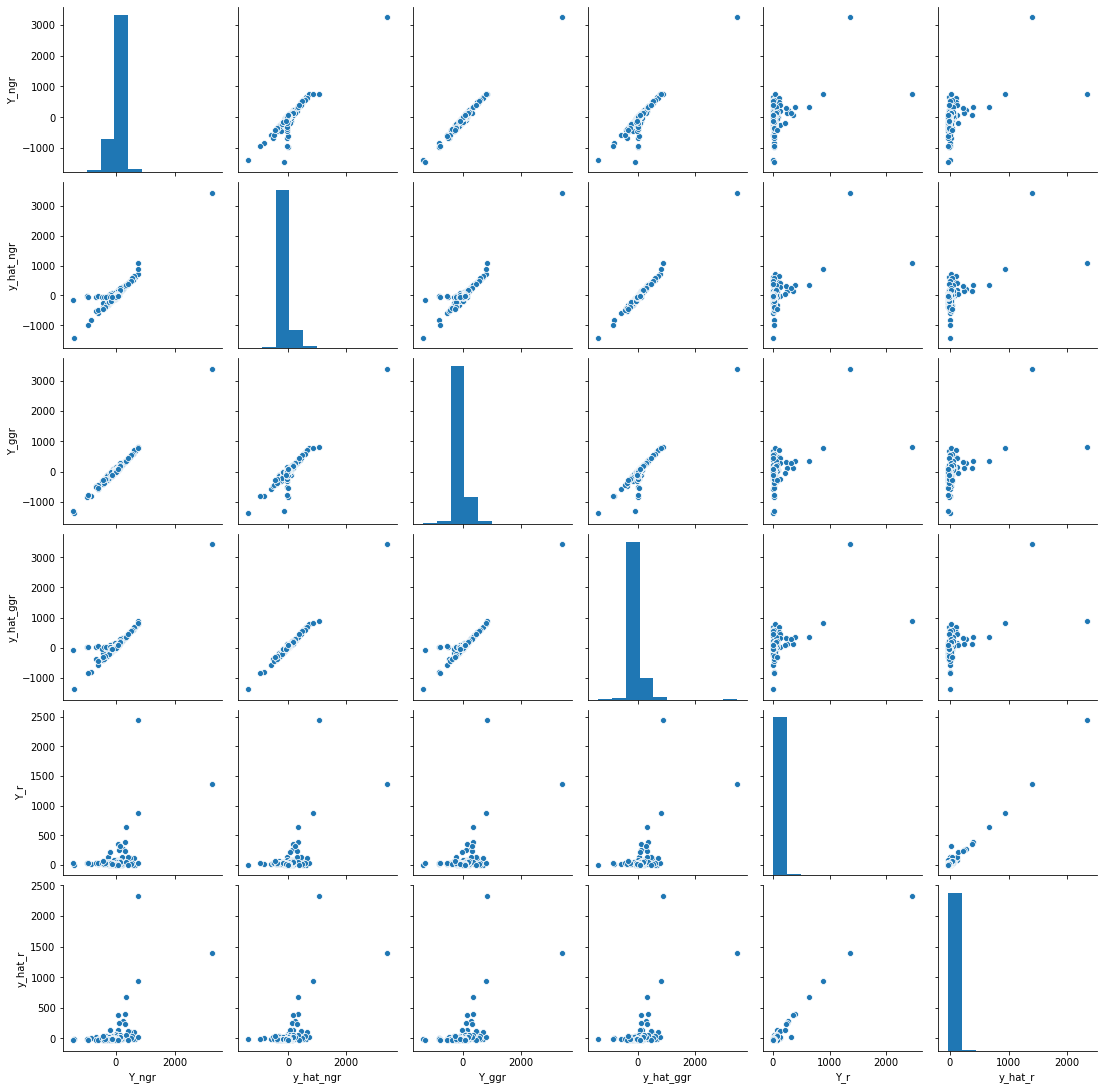

In [103]:
sns.pairplot(DF_pred)

In [104]:
mse_ngr=mean_squared_error(Y_ngr,y_hat_ngr)
mse_ggr=mean_squared_error(Y_ggr,y_hat_ggr)
mse_r=mean_squared_error(Y_r,y_hat_r)

print('MSE NGR:',mse_ngr,'MSE GGR:',mse_ggr,'MSE Stake ratio:',mse_r)

MSE NGR: 10276.57048698769 MSE GGR: 7288.267878312439 MSE Stake ratio: 867.1315611854661


# ARIMA

In [92]:
player_char_df_train.shape

(2637, 17)

In [93]:
arima_mask_ex=player_char_df_train['user'].isin(df_ex['user'])
player_char_df_train=player_char_df_train[~arima_mask_ex]
player_char_df_train.shape

(2523, 17)

In [94]:
df_train_arima=player_char_df_train[(player_char_df_train['seniority']>15)&(player_char_df_train['num_bet_days']>3)]
df_train_arima=df_train_arima[(df_train_arima['user']!=544741)&
                             (df_train_arima['user']!=553572)&
                             (df_train_arima['user']!=552631)&
                             (df_train_arima['user']!=570552)]

In [124]:
y_pred=[]
for user in df_train_arima['user'].unique():
    df_user=df_train[df_train['user_id']==user]
    df_user['date']=df_user['placed_time'].dt.date
    df_ar=df_user.copy()
    df_ar=df_ar.set_index('date')
    df_ar.freebet_stake=df_ar.freebet_stake.fillna(value=0,inplace=False)
    df_ar=df_ar.sort_index()
    df_ar['in_out']=np.where((df_ar['settlement_status']=='DEPOSIT')|(df_ar['settlement_status']=='WITHDRAWAL'),df_ar['win_or_lose_amount'],0)
    
    df_ar['GGR']=0
    df_ar['NGR']=0
    GGR=0
    NGR=0

    for i,inout in enumerate(df_ar['in_out']):
        if (i==0)&(inout==0):
            df_ar['GGR'][i]=GGR
            NGR=NGR+df_ar['freebet_stake'][i]
            df_ar['NGR'][i]=GGR-NGR
      
        elif (i==0)&(inout!=0):
            if df_ar['settlement_status'][i]=='DEPOSIT':
                GGR=GGR+inout
                df_ar['GGR'][i]=GGR
                NGR=NGR+df_ar['freebet_stake'][i]
                df_ar['NGR'][i]=GGR-NGR
            else:
                GGR=GGR-inout
                df_ar['GGR'][i]=GGR
                NGR=NGR+df_ar['freebet_stake'][i]
                df_ar['NGR'][i]=GGR-NGR
            
        elif inout>0:
            if df_ar['settlement_status'][i]=='DEPOSIT':
                GGR=GGR+inout
                df_ar['GGR'][i]=GGR
                NGR=NGR+df_ar['freebet_stake'][i]
                df_ar['NGR'][i]=GGR-NGR
            else:
                GGR=GGR-inout
                df_ar['GGR'][i]=GGR 
                NGR=NGR+df_ar['freebet_stake'][i]
                df_ar['NGR'][i]=GGR-NGR
    
        elif inout==0:
            df_ar['GGR'][i]=GGR
            NGR=NGR+df_ar['freebet_stake'][i]
            df_ar['NGR'][i]=GGR-NGR
    
    
    df_arima=df_ar[['GGR','NGR']]
    df_arima['Stake_ratio']=pd.DataFrame(df_ar.groupby('date')['total_stake'].sum())['total_stake'].cumsum().mul(0.14)
    
    df_arima_NGR=pd.DataFrame(df_arima.groupby('date')['NGR'].last())
    df_arima_GGR=pd.DataFrame(df_arima.groupby('date')['GGR'].last())
    df_arima_Stake_r=pd.DataFrame(df_arima.groupby('date')['Stake_ratio'].last())

    
    if df_arima_Stake_r.shape[0]<21:
        start_date=df_arima.index[0]
        end_date=start_date+datetime.timedelta(21)
        df_arima_NGR.loc[end_date]=np.nan
        df_arima_GGR.loc[end_date]=np.nan
        df_arima_Stake_r.loc[end_date]=np.nan
    else:
        pass
        
    df_arima_NGR=df_arima_NGR.asfreq('d')
    df_arima_GGR=df_arima_GGR.asfreq('d')
    df_arima_Stake_r=df_arima_Stake_r.asfreq('d')


    df_arima_NGR=df_arima_NGR.fillna(method='ffill')
    df_arima_GGR=df_arima_GGR.fillna(method='ffill')
    df_arima_Stake_r=df_arima_Stake_r.fillna(method='ffill')
    df_arima_Stake_r=df_arima_Stake_r.fillna(0)

    
    
    ar_model_stake_r=ARIMA(df_arima_Stake_r,order=(1,0,1))
    ar_model_stake_r_results=ar_model_stake_r.fit(start_params=(2,0,0))
    stake_r_pred=ar_model_stake_r_results.predict(end=90)[90]
    exog=ar_model_stake_r_results.predict(end=90)
    
    try:
        #end_data=df_arima_NGR.shape[0]
        end_data=21
    
        ar_model_NGR=ARIMA(df_arima_NGR,order=(1,0,1),exog=exog[:end_data])
        ar_model_NGR_results=ar_model_NGR.fit(start_params=(2,0,0,0))
        NGR_pred=ar_model_NGR_results.predict(end=90,exog=exog)[90]
        
        ar_model_GGR=ARIMA(df_arima_GGR,order=(1,0,1),exog=exog[:end_data])
        ar_model_GGR_results=ar_model_GGR.fit(start_params=(2,0,0,0))
        GGR_pred=ar_model_GGR_results.predict(end=90,exog=exog)[90]
   
    except: 
        ValueError
        
        ar_model_NGR=ARIMA(df_arima_NGR,order=(1,0,1))
        ar_model_NGR_results=ar_model_NGR.fit(start_params=(2,0,0))
        NGR_pred=ar_model_NGR_results.predict(end=90)[90]
        
        ar_model_GGR=ARIMA(df_arima_GGR,order=(1,0,1))
        ar_model_GGR_results=ar_model_GGR.fit(start_params=(2,0,0))
        GGR_pred=ar_model_GGR_results.predict(end=90)[90]
   
         
    y_pred.append([user,NGR_pred,GGR_pred,stake_r_pred])

C:\Users\kobi_z\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\kobi_z\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kobi_z\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C

C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWa

C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWa

C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWa

C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWa

C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kobi_z\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\U

In [125]:
arima_pred=pd.DataFrame(y_pred)
arima_pred.columns=['user','y_hat_NGR','y_hat_GGR','y_hat_stake_ratio']
arima_pred_df=pd.merge(left=arima_pred,right=player_char_df_y,left_on='user',right_on='user')

In [126]:
arima_pred_df.corr()

,user,y_hat_NGR,y_hat_GGR,y_hat_stake_ratio,GGR_y,NGR_y,Stake_ratio_y
user,1.000000,-0.013887,-0.012368,0.007938,-0.037082,-0.037124,-0.015652
y_hat_NGR,-0.013887,1.000000,0.998221,0.755509,0.728748,0.727984,0.712438
y_hat_GGR,-0.012368,0.998221,1.000000,0.756778,0.736266,0.733278,0.715824
y_hat_stake_ratio,0.007938,0.755509,0.756778,1.000000,0.569462,0.567028,0.906752
GGR_y,-0.037082,0.728748,0.736266,0.569462,1.000000,0.997728,0.620521
NGR_y,-0.037124,0.727984,0.733278,0.567028,0.997728,1.000000,0.610961
Stake_ratio_y,-0.015652,0.712438,0.715824,0.906752,0.620521,0.610961,1.000000


In [100]:
#arima_pred=arima_pred_df[['user','y_hat_NGR','y_hat_GGR','y_hat_stake_ratio']]
#arima_pred.shape

In [107]:
arima_pred=arima_pred.rename(columns={'y_hat_NGR':'y_hat_ngr','y_hat_GGR':'y_hat_ggr','y_hat_stake_ratio':'y_hat_r'})

In [108]:
Total_pred=pd.concat([svm_pred,arima_pred,df_ex])

NameError: name 'svm_pred' is not defined

In [290]:
df_ex.shape

(1175, 2)

In [106]:
Total_pred.shape

NameError: name 'Total_pred' is not defined

In [292]:
len(df['user_id'].unique())

2000

In [293]:
len(Total_pred['user'].unique())

2000

In [294]:
Total_pred.to_csv(r'C:\Users\kobi_z\Documents\Data Science\Simpool Projects\Total Predication exog.csv')

In [295]:
Total_pred

,user,y_hat_ngr,y_hat_ggr,y_hat_r,comment
0,521500,-127.528478,-53.050003,-22.798992,NaN
1,521076,-56.006670,8.714798,-21.695104,NaN
2,518785,-169.414764,-118.804171,-14.111057,NaN
3,521872,-45.791695,28.143962,-2.632107,NaN
4,521887,-51.724819,7.099176,-21.047878,NaN
5,522036,-60.524645,0.561342,-27.028034,NaN
6,521708,-12.917414,20.002810,-13.559939,NaN
7,522163,54.140307,94.528516,5.859621,NaN
8,496057,-17.326508,28.709180,-21.951319,NaN
9,522504,-49.287400,6.398592,-25.065319,NaN
